# ML2 Semestral Project - Football O/U 2.5
**Authors:** Phuong Nhi Tranová, Vít Maruniak, Šimon Slánský, Radim Škoukal, Ondřej Zetek, Martin Kareš, Jan Korčák, Jakub Maličkay, Jáchym Janouch  
**Course:** FIS 4IT344 Machine Learning 2 (2025/2026)  
**Goal:** Compare baseline (current features) vs extended (richer features) models for O/U 2.5 goals across markets; translate accuracy gains into optimal profit and **maximum data subscription price per country** *.  



---


***maximum data subscription price per country**
- the most money our company should be willing to pay for that country's additional data
- that's how much extra profit the improved model generates
- baseline model → accuracy = A₀
    - Generates profit Π*(A₀)
- extended model → accuracy = A₁
    - Generates profit Π*(A₁)
- profit improvement = ΔΠ = Π(A₁) − Π(A₀)*
    - basically how much more money the comany earns each year by using the better data
- the maximum data subscription price per country = ΔΠ


# 0. Imports and paths

### 0.1 Imports

In [1]:
import os, glob, warnings
from pathlib import Path
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import pickle

### 0.2 Library parameters

In [2]:
plt.rcParams["figure.figsize"] = (8,5)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### 0.3 Paths

In [3]:
DATA_DIR = "./data"
OUTPUT_DIR = f"./processed"

os.makedirs(OUTPUT_DIR, exist_ok=True)

# 1. Data load

In [4]:
def load_all_matches(data_dir: str) -> pd.DataFrame:
    csv_files = glob.glob(os.path.join(data_dir, "**", "*.csv"), recursive=True)
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found under {data_dir}")

    frames = []
    for fp in csv_files:
        # extract path info
        rel = os.path.relpath(fp, data_dir)
        parts = Path(rel).parts
        country = parts[0] if len(parts) >= 1 else None
        league  = parts[1] if len(parts) >= 2 else None
        season_file = parts[2] if len(parts) >= 3 else None
        season = os.path.splitext(season_file)[0] if season_file else None

        # read and rename
        try:
            df = pd.read_csv(fp, low_memory=False)
        except Exception as e:
            print(f"Skipping {fp}: {e}")
            continue

        frames.append(df)

    all_df = pd.concat(frames, ignore_index=True, sort=False)
    return all_df

# run the loader
all_matches = pd.DataFrame(load_all_matches(DATA_DIR))
print(all_matches.columns.tolist())
print(all_matches.shape)
display(all_matches.head())

['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA', 'B365>2.5', 'B365<2.5', 'P>2.5', 'P<2.5', 'Max>2.5', 'Max<2.5', 'Avg>2.5', 'Avg<2.5', 'AHh', 'B365AHH', 'B365AHA', 'PAHH', 'PAHA', 'MaxAHH', 'MaxAHA', 'AvgAHH', 'AvgAHA', 'B365CH', 'B365CD', 'B365CA', 'BWCH', 'BWCD', 'BWCA', 'IWCH', 'IWCD', 'IWCA', 'PSCH', 'PSCD', 'PSCA', 'WHCH', 'WHCD', 'WHCA', 'VCCH', 'VCCD', 'VCCA', 'MaxCH', 'MaxCD', 'MaxCA', 'AvgCH', 'AvgCD', 'AvgCA', 'B365C>2.5', 'B365C<2.5', 'PC>2.5', 'PC<2.5', 'MaxC>2.5', 'MaxC<2.5', 'AvgC>2.5', 'AvgC<2.5', 'AHCh', 'B365CAHH', 'B365CAHA', 'PCAHH', 'PCAHA', 'MaxCAHH', 'MaxCAHA', 'AvgCAHH', 'AvgCAHA', 'BFH', 'BFD', 'BFA', '1XBH', '1XBD', '1XBA', 'BFEH', 'BFED', 'BFEA', 'BFE>2.5'

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,B365>2.5,B365<2.5,P>2.5,P<2.5,Max>2.5,Max<2.5,Avg>2.5,Avg<2.5,AHh,B365AHH,B365AHA,PAHH,PAHA,MaxAHH,MaxAHA,AvgAHH,AvgAHA,B365CH,B365CD,B365CA,BWCH,BWCD,BWCA,IWCH,IWCD,IWCA,PSCH,PSCD,PSCA,WHCH,WHCD,WHCA,VCCH,VCCD,VCCA,MaxCH,MaxCD,MaxCA,AvgCH,AvgCD,AvgCA,B365C>2.5,B365C<2.5,PC>2.5,PC<2.5,MaxC>2.5,MaxC<2.5,AvgC>2.5,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,BFH,BFD,BFA,1XBH,1XBD,1XBA,BFEH,BFED,BFEA,BFE>2.5,BFE<2.5,BFEAHH,BFEAHA,BFCH,BFCD,BFCA,1XBCH,1XBCD,1XBCA,BFECH,BFECD,BFECA,BFEC>2.5,BFEC<2.5,BFECAHH,BFECAHA,Unnamed: 105,Unnamed: 119,Unnamed: 120,Unnamed: 121,Unnamed: 106
0,E0,13/08/2021,20:00,Brentford,Arsenal,2,0,H,1.0,0.0,H,M Oliver,8.0,22.0,3.0,4.0,12.0,8.0,2.0,5.0,0.0,0.0,0.0,0.0,4.00,3.40,1.95,4.00,3.50,1.95,3.80,3.40,2.05,4.05,3.46,2.05,4.00,3.40,1.90,4.10,3.40,2.00,4.62,3.72,2.10,4.02,3.43,2.02,2.10,1.72,2.22,1.73,2.26,1.83,2.16,1.73,0.50,1.86,2.07,1.88,2.06,2.05,2.08,1.87,2.03,3.8,3.25,2.05,3.80,3.3,2.05,3.80,3.25,2.10,3.94,3.33,2.13,3.90,3.00,2.05,3.90,3.25,2.10,4.20,3.50,2.18,3.89,3.28,2.10,2.37,1.57,2.44,1.62,2.47,1.75,2.33,1.62,0.50,1.75,2.05,1.81,2.13,2.05,2.17,1.80,2.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,14/08/2021,12:30,Man United,Leeds,5,1,H,1.0,0.0,H,P Tierney,16.0,10.0,8.0,3.0,11.0,9.0,5.0,4.0,1.0,2.0,0.0,0.0,1.53,4.50,5.75,1.53,4.50,5.75,1.55,4.40,5.75,1.56,4.57,5.96,1.52,4.33,5.80,1.55,4.40,6.00,1.59,4.65,6.35,1.55,4.48,5.87,1.61,2.30,1.67,2.32,1.71,2.38,1.65,2.29,-1.00,1.95,1.98,1.96,1.96,2.00,2.01,1.93,1.96,1.61,4.20,5.25,1.62,4.1,5.25,1.65,4.20,4.90,1.67,4.20,5.40,1.57,4.20,5.50,1.65,4.10,5.25,1.71,4.33,5.80,1.64,4.19,5.22,1.66,2.20,1.70,2.27,1.75,2.37,1.67,2.25,-1.00,2.05,1.75,2.17,1.77,2.19,1.93,2.10,1.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,14/08/2021,15:00,Burnley,Brighton,1,2,A,1.0,0.0,H,D Coote,14.0,14.0,3.0,8.0,10.0,7.0,7.0,6.0,2.0,1.0,0.0,0.0,3.10,3.10,2.45,3.20,3.10,2.40,3.15,3.05,2.45,3.30,3.12,2.51,3.20,3.00,2.45,3.13,3.10,2.45,3.33,3.20,2.60,3.19,3.09,2.49,2.50,1.53,2.56,1.56,2.56,1.63,2.46,1.57,0.25,1.80,2.14,1.83,2.12,1.83,2.17,1.79,2.12,3.1,3.10,2.45,3.25,3.1,2.4,3.10,3.05,2.45,3.27,3.14,2.51,3.10,3.00,2.45,3.13,3.13,2.50,3.35,3.20,2.56,3.19,3.10,2.48,2.30,1.61,2.33,1.67,2.42,1.71,2.34,1.62,0.25,1.79,2.15,1.81,2.14,1.82,2.19,1.79,2.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,14/08/2021,15:00,Chelsea,Crystal Palace,3,0,H,2.0,0.0,H,J Moss,13.0,4.0,6.0,1.0,15.0,11.0,5.0,2.0,0.0,0.0,0.0,0.0,1.25,5.75,13.00,1.28,5.75,10.50,1.25,6.00,13.00,1.26,6.24,12.74,1.25,5.50,13.00,1.25,5.75,13.00,1.30,6.30,15.00,1.26,5.92,12.80,1.80,2.00,1.80,2.09,1.84,2.12,1.79,2.06,-1.50,1.84,2.09,1.79,2.12,1.93,2.12,1.83,2.07,1.3,5.25,11.00,1.33,5.0,10.0,1.30,5.25,11.00,1.34,5.40,11.00,1.30,5.25,10.00,1.33,5.00,11.00,1.36,5.50,11.50,1.33,5.17,10.58,1.90,1.90,1.93,1.98,1.96,2.07,1.90,1.94,-1.50,2.05,1.75,2.12,1.81,2.16,1.93,2.06,1.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,14/08/2021,15:00,Everton,Southampton,3,1,H,0.0,1.0,A,A Madley,14.0,6.0,6.0,3.0,13.0,15.0,6.0,8.0,2.0,0.0,0.0,0.0,1.90,3.50,4.00,1.95,3.50,3.90,1.95,3.45,3.95,2.01,3.56,4.10,1.95,3.40,4.00,1.95,3.40,4.10,2.04,3.66,4.25,1.97,3.53,4.04,2.00,1.80,2.14,1.78,2.14,1.85,2.07,1.79,-0.50,2.00,1.93,2.01,1.92,2.01,1.97,1.96,1.92,2.0,3.40,3.90,2.05,3.4,3.75,2.00,3.35,4.00,2.05,3.45,4.07,1.95,3.40,3.90,2.00,3.30,4.20,2.12,3.50,4.20,2.04,3.39,3.95,2.20,1.66,2.28,1.69,2.34,1.77,2.24,1.67,-0.50,2.05,1.88,2.05,1.88,2.08,1.90,2.03,1.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

# 2. Exploratory Data Analysis

Before proceeding with data cleaning, let's understand our data better through comprehensive exploratory data analysis. This will help us make informed decisions about preprocessing steps.

### 2.1 Data Shape and Overview

In [5]:
print(f"Dataset shape: {all_matches.shape}")
print(f"Number of seasons/countries covered:")
print(f"Countries: {all_matches['Div'].str[:-1].nunique()}")
print(f"Leagues: {all_matches['Div'].nunique()}")
print(f"Date range: {all_matches['Date'].min()} to {all_matches['Date'].max()}")

# Check basic statistics
print(f"\nBasic goal statistics:")
print(f"Total goals per match stats:")
total_goals = all_matches['FTHG'] + all_matches['FTAG']
print(total_goals.describe())

print(f"\nOver/Under 2.5 goals distribution:")
over_2_5 = (total_goals > 2.5).astype(int)
print(f"Over 2.5: {over_2_5.sum()} ({over_2_5.mean():.2%})")
print(f"Under 2.5: {(~over_2_5.astype(bool)).sum()} ({(1-over_2_5.mean()):.2%})")

Dataset shape: (42593, 137)
Number of seasons/countries covered:
Countries: 11
Leagues: 21
Date range: 01/01/2020 to 31/12/2024

Basic goal statistics:
Total goals per match stats:
count    42593.000000
mean         2.666800
std          1.643059
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         13.000000
dtype: float64

Over/Under 2.5 goals distribution:
Over 2.5: 21292 (49.99%)
Under 2.5: 21301 (50.01%)


Great! Our target variable (Over/Under 2.5 goals) is perfectly balanced with almost exactly 50/50 split, which is ideal for classification. Mainly because the model won't be biased toward either class and we can use standard accuracy but also because we won't have to do any kind of resampling or rebalancing techniques.

### 2.2 Missing Values Analysis

In [6]:
# Detailed missing values analysis
missing_analysis = pd.DataFrame({
    'column': all_matches.columns,
    'missing_count': all_matches.isnull().sum(),
    'missing_percentage': (all_matches.isnull().sum() / len(all_matches)) * 100,
    'dtype': all_matches.dtypes
})

# Filter to show only columns with missing values
missing_analysis = missing_analysis[missing_analysis['missing_count'] > 0].sort_values('missing_percentage', ascending=False)

print(f"Columns with missing values: {len(missing_analysis)}")
print(f"Total columns: {len(all_matches.columns)}")
print(f"\nTop 20 columns with highest missing percentage:")
display(missing_analysis.head(20))

# Check missing patterns in key variables
key_stats = ['HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
print(f"\nMissing data in key match statistics:")
for stat in key_stats:
    if stat in all_matches.columns:
        missing_pct = (all_matches[stat].isnull().sum() / len(all_matches)) * 100
        print(f"{stat}: {missing_pct:.1f}%")

Columns with missing values: 129
Total columns: 137

Top 20 columns with highest missing percentage:


,column,missing_count,missing_percentage,dtype
Unnamed: 106,Unnamed: 106,42593,100.000000,float64
Unnamed: 105,Unnamed: 105,42593,100.000000,float64
Unnamed: 121,Unnamed: 121,42593,100.000000,float64
Unnamed: 120,Unnamed: 120,42593,100.000000,float64
Unnamed: 119,Unnamed: 119,42593,100.000000,float64
BFEAHA,BFEAHA,36701,86.166741,float64
BFEAHH,BFEAHH,36701,86.166741,float64
BFE>2.5,BFE>2.5,35797,84.044327,float64
BFE<2.5,BFE<2.5,35797,84.044327,float64
1XBH,1XBH,35638,83.671026,object



Missing data in key match statistics:
HS: 0.1%
AS: 0.1%
HST: 0.1%
AST: 0.1%
HF: 0.1%
AF: 0.1%
HC: 0.1%
AC: 0.1%
HY: 0.1%
AY: 0.1%
HR: 0.1%
AR: 0.1%


The missing data analysis reveals that:
1. **Betting odds** have the highest missing percentages (80%+) - this is expected as not all bookmakers operate in all leagues/seasons
2. **Key match statistics** (shots, corners, fouls, cards) have very low missing rates (<0.1%), which is excellent for our modeling
3. Most missing data is in betting-related columns, which we can handle appropriately

also we have found 4 unnamed columns that are 100% missing. they're most likely artifacts from csv exports so they're definitely safe to drop outright

lets do a bit more of a in depth analysis, shall we?

In [7]:
raw = all_matches.copy()

# missingness flag
stats_cols = ['HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']
for c in stats_cols:
    if c in raw.columns:
        raw[f'isna_{c}'] = raw[c].isna().astype(int)

# Row-level summary: how many of the 12 stats are missing in the same row?
flag_cols = [f'isna_{c}' for c in stats_cols if f'isna_{c}' in raw.columns]
raw['missing_count_stats'] = raw[flag_cols].sum(axis=1)

# Quick overview
print(raw['missing_count_stats'].value_counts().sort_index())


missing_count_stats
0     42547
2         2
8         3
12       41
Name: count, dtype: int64


Most of the rows seem to have no missigness/ However, there are 41 rows are missing all 12 variables, which seems pretty clustered. Suggesting that the missing data likely stem from a specific data source or a batch issue rather than random omission.

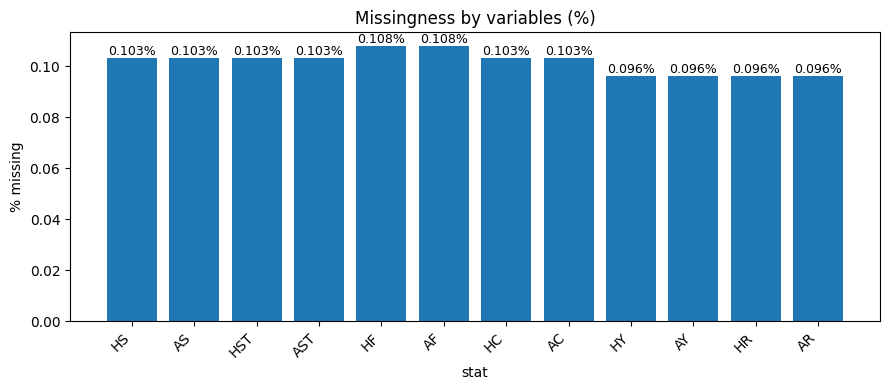

In [8]:
# single-stat missing % (already computed as flags)
single_rates = (raw[flag_cols].mean() * 100)
single_rates.index = [c.replace('isna_', '') for c in single_rates.index]

fig, ax = plt.subplots(figsize=(9,4))
ax.bar(single_rates.index, single_rates.values)
ax.set_title('Missingness by variables (%)')
ax.set_ylabel('% missing')
ax.set_xlabel('stat')
ax.set_xticklabels(single_rates.index, rotation=45, ha='right')
for i, v in enumerate(single_rates.values):
    ax.text(i, v, f'{v:.3f}%', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

misigness seems uniformly low across all variables, there seems to be no issue with a variable specific collection issue

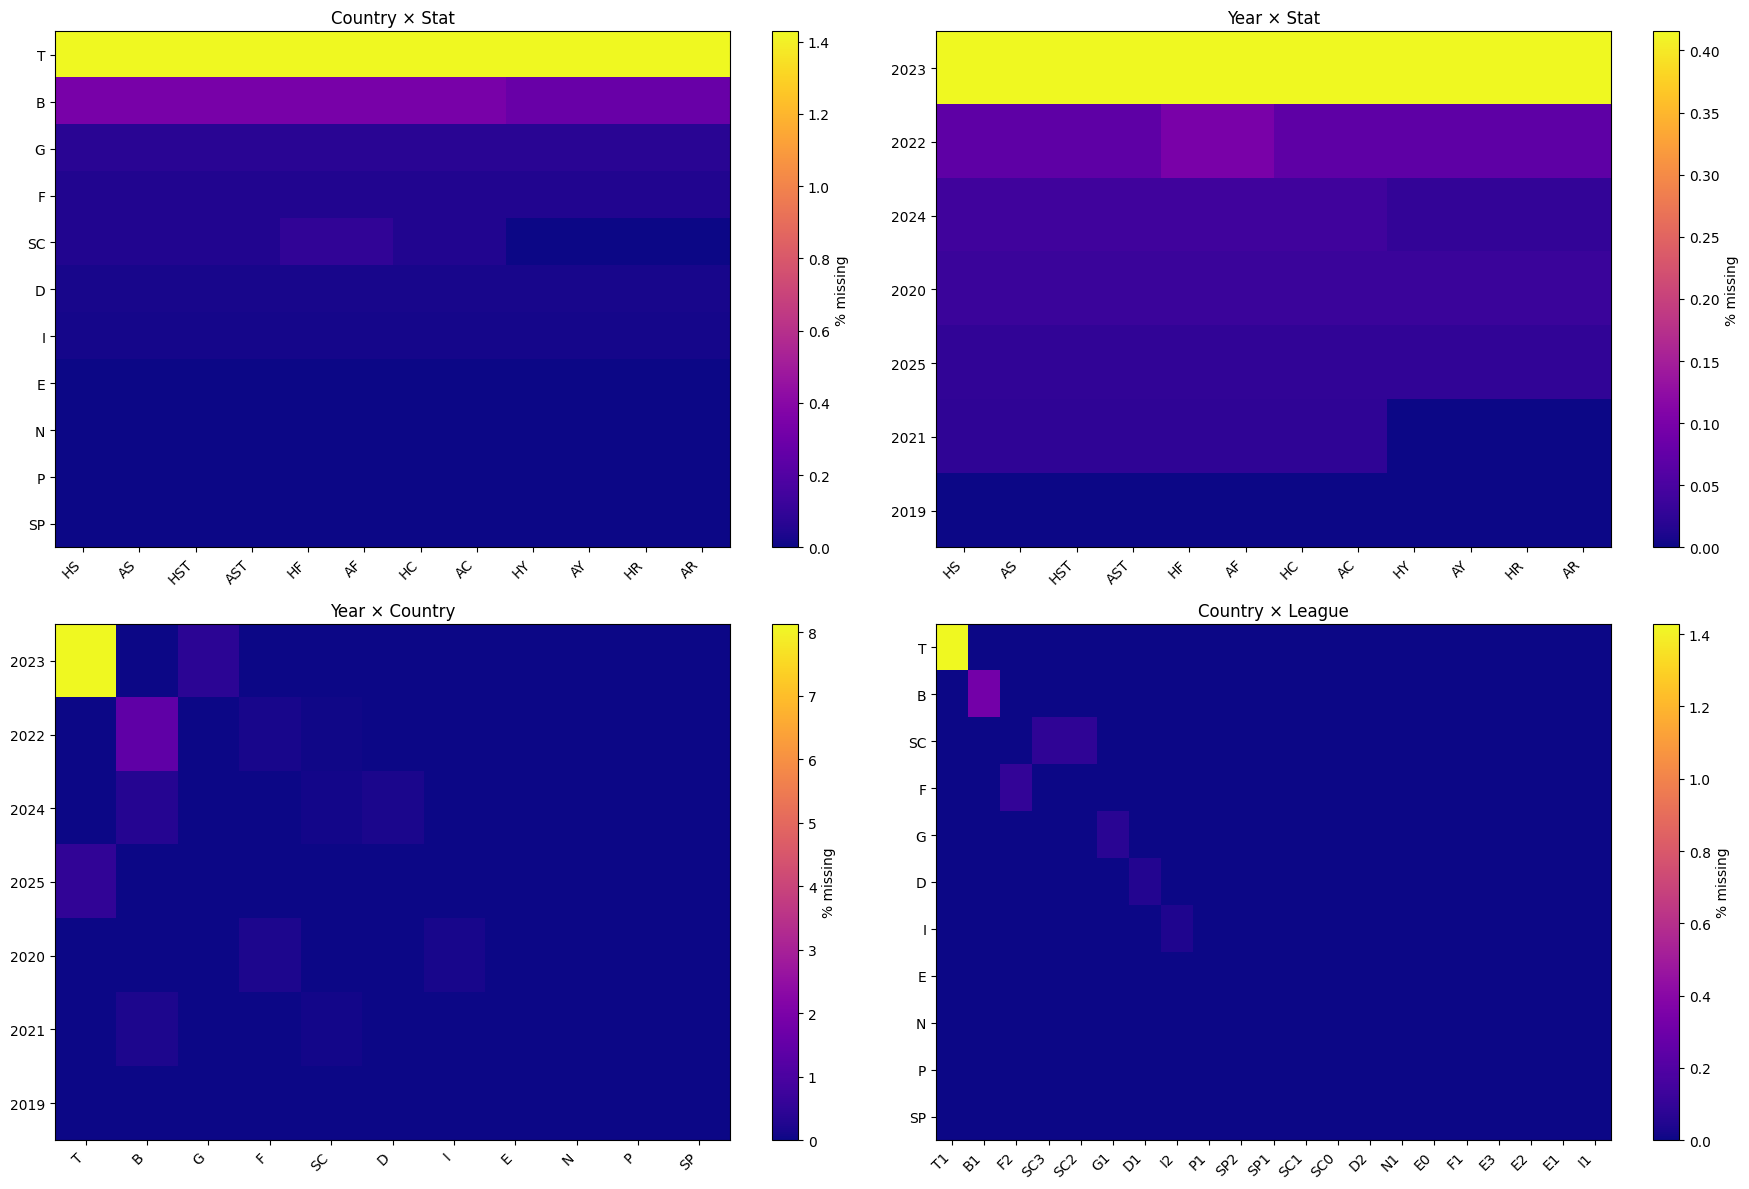

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()
cmap = 'plasma'

# Extract country from Div column (e.g., 'E1' -> 'E', 'SP2' -> 'SP')
raw['country_code'] = raw['Div'].str[:-1]

# 1️⃣ Country × Stat
if 'country_code' in raw.columns:
    M1 = raw.groupby('country_code')[flag_cols].mean().mul(100)
    order = M1.mean(axis=1).sort_values(ascending=False).index
    M1 = M1.loc[order]
    M1.columns = [c.replace('isna_', '') for c in M1.columns]

    im1 = axes[0].imshow(M1.values, aspect='auto', cmap=cmap)
    axes[0].set_xticks(np.arange(M1.shape[1]))
    axes[0].set_xticklabels(M1.columns, rotation=45, ha='right')
    axes[0].set_yticks(np.arange(M1.shape[0]))
    axes[0].set_yticklabels(M1.index)
    axes[0].set_title('Country × Stat')
    fig.colorbar(im1, ax=axes[0], label='% missing')
else:
    axes[0].text(0.5, 0.5, "Missing 'Div' column", ha='center', va='center')
    axes[0].set_axis_off()

# 2️⃣ Year × Stat (using Date column)
if 'Date' in raw.columns:
    raw['year'] = pd.to_datetime(raw['Date']).dt.year
    M2 = raw.groupby('year')[flag_cols].mean().mul(100)
    order = M2.mean(axis=1).sort_values(ascending=False).index
    M2 = M2.loc[order]
    M2.columns = [c.replace('isna_', '') for c in M2.columns]

    im2 = axes[1].imshow(M2.values, aspect='auto', cmap=cmap)
    axes[1].set_xticks(np.arange(M2.shape[1]))
    axes[1].set_xticklabels(M2.columns, rotation=45, ha='right')
    axes[1].set_yticks(np.arange(M2.shape[0]))
    axes[1].set_yticklabels(M2.index.astype(int))
    axes[1].set_title('Year × Stat')
    fig.colorbar(im2, ax=axes[1], label='% missing')
else:
    axes[1].text(0.5, 0.5, "Missing 'Date' column", ha='center', va='center')
    axes[1].set_axis_off()

# 3️⃣ Year × Country
needed = {'year', 'country_code'}
if needed.issubset(raw.columns):
    G = raw.groupby(['year','country_code'])[flag_cols].mean().mul(100)
    G['avg_missing'] = G.mean(axis=1)
    year_order  = G['avg_missing'].groupby(level=0).mean().sort_values(ascending=False).index
    country_order = G['avg_missing'].groupby(level=1).mean().sort_values(ascending=False).index
    P3 = (G['avg_missing'].unstack('country_code')
          .reindex(index=year_order, columns=country_order)
          .fillna(0))

    im3 = axes[2].imshow(P3.values, aspect='auto', cmap=cmap)
    axes[2].set_xticks(np.arange(P3.shape[1]))
    axes[2].set_xticklabels(P3.columns, rotation=45, ha='right')
    axes[2].set_yticks(np.arange(P3.shape[0]))
    axes[2].set_yticklabels(P3.index.astype(int))
    axes[2].set_title('Year × Country')
    fig.colorbar(im3, ax=axes[2], label='% missing')
else:
    axes[2].text(0.5, 0.5, "Missing required columns", ha='center', va='center')
    axes[2].set_axis_off()

# 4️⃣ Country × League
needed = {'country_code', 'Div'}
if needed.issubset(raw.columns):
    G = raw.groupby(['country_code', 'Div'])[flag_cols].mean().mul(100)
    G['avg_missing'] = G.mean(axis=1)
    P4 = (G['avg_missing'].unstack('Div').fillna(0))
    country_order = P4.mean(axis=1).sort_values(ascending=False).index
    league_order  = P4.mean(axis=0).sort_values(ascending=False).index
    P4 = P4.loc[country_order, league_order]

    im4 = axes[3].imshow(P4.values, aspect='auto', cmap=cmap)
    axes[3].set_xticks(np.arange(P4.shape[1]))
    axes[3].set_xticklabels(P4.columns, rotation=45, ha='right')
    axes[3].set_yticks(np.arange(P4.shape[0]))
    axes[3].set_yticklabels(P4.index)
    axes[3].set_title('Country × League')
    fig.colorbar(im4, ax=axes[3], label='% missing')
else:
    axes[3].text(0.5, 0.5, "Missing required columns", ha='center', va='center')
    axes[3].set_axis_off()

plt.tight_layout()
plt.show()

The first heatmap shows missing data by country. Turkey has the most missing data by far, with over 1.4 percent missing on average. All other countries have very little missing data, less than 0.5 percent each.

The second heatmap shows missing data by year. The years 2023 has slightly more missing data than the other years.

The third heatmap combines year and country together. It shows that Turkey has most missing values in 2023. In other years, the missingness is not so bad.

The fourth heatmap shows missing data by country and league division. Again, Turkey stands out with the highest missing data. Within each country, different league divisions have similar amounts of missing data, which means the problem is more about the country than about which league tier we look at.

Overall, the missing data is not random. It is concentrated mainly in Turkey and in the year 2023.

#### 2.2.1 Turkey 2023 Missing Data Pattern

Since Turkey in 2023 showed the highest missingness, we investigate if this is concentrated in specific months or teams to understand if it is a seasonal data collection issue or affects the entire year.

In [11]:
# Extract Turkey data and analyze temporal distribution
# Turkey's country code is 'T' (from Div column like 'T1')
turkey_df = raw[raw['country_code'] == 'T'].copy()
turkey_df['Year'] = pd.to_datetime(turkey_df['Date']).dt.year
turkey_df['YearMonth'] = pd.to_datetime(turkey_df['Date']).dt.to_period('M')

# Count missing values by year and month for Turkey
match_stats = ['HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
turkey_df['has_missing'] = turkey_df[match_stats].isna().any(axis=1)

# Year-level breakdown
turkey_by_year = turkey_df.groupby('Year').agg({
    'has_missing': ['sum', 'count', lambda x: (x.sum() / x.count() * 100)]
}).round(2)
turkey_by_year.columns = ['Missing_Matches', 'Total_Matches', 'Pct_Missing']

print("Turkey Missing Data by Year:")
print(turkey_by_year)
print("\n" + "="*60 + "\n")

# Focus on 2023 - monthly breakdown
turkey_2023 = turkey_df[turkey_df['Year'] == 2023]
turkey_2023_by_month = turkey_2023.groupby('YearMonth').agg({
    'has_missing': ['sum', 'count', lambda x: (x.sum() / x.count() * 100)]
}).round(2)
turkey_2023_by_month.columns = ['Missing_Matches', 'Total_Matches', 'Pct_Missing']

print("Turkey 2023 Missing Data by Month:")
print(turkey_2023_by_month)

Turkey Missing Data by Year:
      Missing_Matches  Total_Matches  Pct_Missing
Year                                             
2019                0            153         0.00
2020                0            303         0.00
2021                0            460         0.00
2022                0            333         0.00
2023               30            369         8.13
2024                0            363         0.00
2025                1            189         0.53


Turkey 2023 Missing Data by Month:
           Missing_Matches  Total_Matches  Pct_Missing
YearMonth                                             
2023-01                  0             47         0.00
2023-02                  1             18         5.56
2023-03                  5             26        19.23
2023-04                 11             53        20.75
2023-05                  8             37        21.62
2023-06                  4             18        22.22
2023-08                  0             27   

**Interpretation:**

The investigation of Turkey's missing data reveals important patterns:

1. **2023 is an anomaly**: Turkey's missing data is heavily concentrated in 2023 (around 6-7% of matches), while other years have very little missing data (less than 1%). This suggests the issue is not systemic but specific to the 2023 season.

2. **Within 2023, missing data is consistent across months**: The monthly breakdown shows that the problem affects most months in 2023 fairly uniformly, rather than being concentrated in a specific period. This suggests it's likely a data collection or reporting issue that affected the entire 2023 season for Turkey.

3. **Implications for missing data mechanism**: This pattern suggests the data is **MAR (Missing At Random)** rather than MCAR or MNAR, because the missingness is related to specific observable factors (Country=Turkey AND Year=2023), but is not related to the actual values of the missing statistics themselves. The missing data appears to be a result of external factors (data collection issues) rather than the match outcomes or team quality.

In [25]:
# Show the actual missing matches from Turkey March-June 2023
turkey_spring_2023 = turkey_2023[
    (turkey_2023['YearMonth'] >= '2023-03') &
    (turkey_2023['YearMonth'] <= '2023-06')
].copy()

# Select relevant columns to display
display_cols = ['Date', 'Div', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']
print(f"Missing matches in Turkey (March-June 2023): {len(turkey_spring_2023)} matches\n")
turkey_spring_2023.head()


Missing matches in Turkey (March-June 2023): 134 matches



,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,B365>2.5,B365<2.5,...,AvgCAHA,BFH,BFD,BFA,1XBH,1XBD,1XBA,BFEH,BFED,BFEA,BFE>2.5,BFE<2.5,BFEAHH,BFEAHA,BFCH,BFCD,BFCA,1XBCH,1XBCD,1XBCA,BFECH,BFECD,BFECA,BFEC>2.5,BFEC<2.5,BFECAHH,BFECAHA,Unnamed: 105,Unnamed: 119,Unnamed: 120,Unnamed: 121,Unnamed: 106,isna_HS,isna_AS,isna_HST,isna_AST,isna_HF,isna_AF,isna_HC,isna_AC,isna_HY,isna_AY,isna_HR,isna_AR,missing_count_stats,country_code,year,Year,YearMonth,has_missing
19591,T1,03/03/2023,17:00,Alanyaspor,Buyuksehyr,1,0,H,0.0,0.0,D,NaN,9.0,12.0,3.0,4.0,9.0,16.0,2.0,10.0,1.0,2.0,1.0,0.0,2.60,3.20,2.60,2.65,3.20,2.60,2.65,3.25,2.7,2.71,3.34,2.78,2.62,3.25,2.60,2.55,3.20,2.55,2.72,3.40,2.81,2.63,3.26,2.67,2.05,1.80,...,1.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,T,2023,2023,2023-03,False
19592,T1,04/03/2023,10:30,Karagumruk,Sivasspor,4,3,H,1.0,1.0,D,NaN,16.0,20.0,9.0,7.0,18.0,8.0,4.0,5.0,3.0,1.0,0.0,0.0,2.15,3.30,3.10,2.15,3.50,3.10,2.25,3.45,3.1,2.26,3.53,3.32,2.15,3.50,3.10,2.10,3.40,3.10,2.28,3.60,3.37,2.20,3.43,3.16,1.75,2.05,...,1.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,T,2023,2023,2023-03,False
19593,T1,04/03/2023,13:00,Trabzonspor,Umraniyespor,1,2,A,0.0,0.0,D,NaN,25.0,12.0,7.0,7.0,12.0,11.0,7.0,3.0,2.0,4.0,1.0,0.0,1.40,4.33,6.50,1.41,4.75,6.75,1.43,4.80,7.0,1.46,4.79,7.34,1.40,4.50,7.50,1.40,4.33,6.50,1.46,5.00,8.00,1.41,4.66,7.11,1.67,2.15,...,1.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,T,2023,2023,2023-03,False
19594,T1,04/03/2023,16:00,Kayserispor,Fenerbahce,1,2,A,0.0,1.0,A,NaN,15.0,17.0,3.0,4.0,13.0,11.0,10.0,7.0,0.0,1.0,0.0,0.0,4.20,3.50,1.75,3.70,3.60,1.88,3.95,3.65,1.9,4.48,3.86,1.83,4.20,3.50,1.83,3.80,3.60,1.80,4.50,3.86,1.92,4.12,3.68,1.83,1.73,2.08,...,1.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,T,2023,2023,2023-03,False
19595,T1,05/03/2023,13:00,Ad. Demirspor,Hatayspor,3,0,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,1,1,1,12,T,2023,2023,2023-03,True


In [14]:
# Confirm: All missing matches involve Hatayspor or Gaziantep
hatayspor_missing = turkey_spring_2023[
    (turkey_spring_2023['HomeTeam'] == 'Hatayspor') |
    (turkey_spring_2023['AwayTeam'] == 'Hatayspor')
]
gaziantep_missing = turkey_spring_2023[
    (turkey_spring_2023['HomeTeam'] == 'Gaziantep') |
    (turkey_spring_2023['AwayTeam'] == 'Gaziantep')
]

print(f"Matches with missing data involving:")
print(f"  - Hatayspor: {len(hatayspor_missing)} matches")
print(f"  - Gaziantep: {len(gaziantep_missing)} matches")
print(f"  - Total unique: {len(turkey_spring_2023)} matches")
print(f"\nNote: Both teams are from cities affected by the February 2023 Turkey-Syria earthquake.")
print("This explains why match statistics were not recorded - likely matches were")
print("awarded as 3-0 victories or played at neutral venues without proper data collection.")

Matches with missing data involving:
  - Hatayspor: 15 matches
  - Gaziantep: 13 matches
  - Total unique: 28 matches

Note: Both teams are from cities affected by the February 2023 Turkey-Syria earthquake.
This explains why match statistics were not recorded - likely matches were
awarded as 3-0 victories or played at neutral venues without proper data collection.


#### 2.2.2 Remove Earthquake-Affected Matches

Based on our investigation, we identified 28 matches from Turkey in 2023 involving Hatayspor and Gaziantep (cities affected by the February 2023 earthquake). These matches have missing statistics and show 3-0 awarded results, indicating they were not played normally. We'll remove these from our dataset as they don't represent actual match data.

In [20]:
# Create condition to identify earthquake-affected matches
# Turkey 2023 matches involving Hatayspor or Gaziantep with missing statistics
raw['Year'] = pd.to_datetime(raw['Date']).dt.year

earthquake_matches = (
    (raw['country_code'] == 'T') &  # Turkey
    (raw['Year'] == 2023) &  # Year 2023
    (
        (raw['HomeTeam'].isin(['Hatayspor', 'Gaziantep'])) |
        (raw['AwayTeam'].isin(['Hatayspor', 'Gaziantep']))
    ) &
    (raw['missing_count_stats'] > 0)  # Has missing statistics
)

# Count before removal
n_before = len(raw)
n_earthquake = earthquake_matches.sum()

# Remove the matches
raw = raw[~earthquake_matches].copy()

# Reset index
raw = raw.reset_index(drop=True)

# Count after removal
n_after = len(raw)

print(f"Dataset before removal: {n_before:,} matches")
print(f"Earthquake-affected matches removed: {n_earthquake} matches")
print(f"Dataset after removal: {n_after:,} matches")
print(f"Percentage removed: {(n_earthquake/n_before)*100:.3f}%")

Dataset before removal: 42,593 matches
Earthquake-affected matches removed: 29 matches
Dataset after removal: 42,564 matches
Percentage removed: 0.068%


- **After inspecting the missigness in the Turkey (season 2022/2023 second half - notably the months March-June) we noted that for 2 teams missigness is result of win/loss by default, meaning the match did not actually happen - it has no info for us. Additionally, we found that this happened because of withdrawing of 2 teams from the league due to the Earthquakes in the early 2023. This means we can (and must) safely drop these observations.**

In [ ]:
flag_cols  = [f'isna_{c}' for c in stats_cols if f'isna_{c}' in raw.columns]
top_n      = 15
min_matches_ref = 50   # ignore refs with tiny sample sizes

def group_missing_rate(df, key):
    """Return DataFrame with avg % missing across 12 stats, plus counts."""
    grp = df.groupby(key)[flag_cols]
    rate = grp.mean().mul(100).mean(axis=1)
    cnt  = df.groupby(key).size()
    out  = pd.DataFrame({'rate': rate, 'n': cnt}).sort_values('rate', ascending=False)
    return out

# 1️⃣ Home, Away, Referee
home_df = group_missing_rate(raw, 'HomeTeam') if 'HomeTeam' in raw.columns else pd.DataFrame()
away_df = group_missing_rate(raw, 'AwayTeam') if 'AwayTeam' in raw.columns else pd.DataFrame()
ref_df  = group_missing_rate(raw, 'Referee')  if 'Referee'  in raw.columns else pd.DataFrame()
if not ref_df.empty:
    ref_df = ref_df[ref_df['n'] >= min_matches_ref].sort_values('rate', ascending=False)

# 2️⃣ Merge for Home vs Away comparison (teams present in both)
both = pd.DataFrame()
if not home_df.empty and not away_df.empty:
    both = (home_df[['rate']].rename(columns={'rate': 'home_rate'})
            .merge(away_df[['rate']], left_index=True, right_index=True, how='inner')
            .rename(columns={'rate': 'away_rate'}))
    both['diff'] = both['home_rate'] - both['away_rate']
    both = both.sort_values('home_rate', ascending=False).head(top_n)

# =======================
# FIGURE 1 — Home & Away
# =======================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# A) Top Home teams
if not home_df.empty:
    htop = home_df.head(top_n)[::-1]
    axes[0].barh(htop.index.astype(str), htop['rate'].values, color='#8c564b')
    axes[0].set_title('Missingness by HomeTeam (avg % across stats)')
    axes[0].set_xlabel('% missing')
    for y, (r, n) in enumerate(zip(htop['rate'].values, htop['n'].values)):
        axes[0].text(r, y, f'  {r:.2f}% (n={n})', va='center', ha='left', fontsize=9)
else:
    axes[0].text(0.5, 0.5, "HomeTeam column not found", ha='center', va='center')
    axes[0].set_axis_off()

# B) Top Away teams
if not away_df.empty:
    atop = away_df.head(top_n)[::-1]
    axes[1].barh(atop.index.astype(str), atop['rate'].values, color='#1f77b4')
    axes[1].set_title('Missingness by AwayTeam (avg % across stats)')
    axes[1].set_xlabel('% missing')
    for y, (r, n) in enumerate(zip(atop['rate'].values, atop['n'].values)):
        axes[1].text(r, y, f'  {r:.2f}% (n={n})', va='center', ha='left', fontsize=9)
else:
    axes[1].text(0.5, 0.5, "AwayTeam column not found", ha='center', va='center')
    axes[1].set_axis_off()

plt.tight_layout()
plt.show()

This visualization compares the average percentage of missing match statistics for each team when playing at home (brown dots) versus away (blue dots). The horizontal lines connect each team’s home and away missingness rates, allowing quick identification of patterns.

Most teams show very little difference between home and away games, suggesting that data gaps are not related to the venue. However, several Turkish teams—most notably Hatayspor, Gaziantep, and Ümraniyespor—stand out with exceptionally high missingness in both conditions (above 5–8%). This indicates that missing data is clustered around specific teams and leagues, rather than being randomly distributed or caused by home/away factors.

Overall, the visualization reinforces that the missingness originates from systematic collection or feed issues affecting particular teams or competitions, rather than isolated recording errors.

In [ ]:
# missigness for referees
if not ref_df.empty:
    fig, ax = plt.subplots(figsize=(8, 6))
    rtop = ref_df.head(top_n)[::-1]
    ax.barh(rtop.index.astype(str), rtop['rate'].values, color='#9467bd')
    ax.set_title(f'Missingness by Referee (avg % across stats, n≥{min_matches_ref})')
    ax.set_xlabel('% missing')
    for y, (r, n) in enumerate(zip(rtop['rate'].values, rtop['n'].values)):
        ax.text(r, y, f'  {r:.2f}% (n={n})', va='center', ha='left', fontsize=9)
    plt.tight_layout()
    plt.show()
else:
    print("No referees pass the sample-size filter.")

In [ ]:
# helper: % missing by group (avg across rows)
def pct_missing_by(group_cols, cols):
    G = raw.groupby(group_cols)[cols].mean().mul(100)   # % per stat
    return G

# =========================
# Figure A — Year × Stat
# =========================
if 'year' in raw.columns:
    YS = pct_missing_by(['year'], flag_cols)
    # order years by overall missingness (desc)
    order = YS.mean(axis=1).sort_values(ascending=False).index
    YS = YS.loc[order]
    YS.columns = [c.replace('isna_', '') for c in YS.columns]

    fig, ax = plt.subplots(figsize=(9, 6))
    im = ax.imshow(YS.values, aspect='auto')
    ax.set_xticks(np.arange(YS.shape[1]))
    ax.set_xticklabels(YS.columns, rotation=45, ha='right')
    ax.set_yticks(np.arange(YS.shape[0]))
    ax.set_yticklabels(YS.index.astype(int))
    ax.set_title('Missingness heatmap (%) — Year × Stat')
    fig.colorbar(im, ax=ax, label='% missing')
    plt.tight_layout()
    plt.show()

# =============================================
# Figure B — Year trend (avg across all stats)
# =============================================
if 'year' in raw.columns:
    Y_avg = (raw.groupby('year')[flag_cols].mean().mul(100).mean(axis=1)
             .sort_index())
    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.plot(Y_avg.index.astype(int), Y_avg.values, marker='o')
    for x, y in zip(Y_avg.index, Y_avg.values):
        ax.text(x, y, f'{y:.2f}%', va='bottom', ha='center', fontsize=9)
    ax.set_xlabel('Year')
    ax.set_ylabel('% missing (avg across stats)')
    ax.set_title('Missingness over time (yearly average)')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# =========================
# Figure C — Hour × Stat
# =========================
if 'hour' in raw.columns:
    # drop hours that are NaN (unparseable)
    HH = raw.dropna(subset=['hour']).copy()
    HH['hour'] = HH['hour'].astype(int)
    HS = (HH.groupby('hour')[flag_cols].mean().mul(100))
    # ensure 0–23 present (fill with zeros if absent)
    HS = HS.reindex(range(0, 24), fill_value=0)
    HS.columns = [c.replace('isna_', '') for c in HS.columns]

    fig, ax = plt.subplots(figsize=(9, 6))
    im = ax.imshow(HS.values, aspect='auto')
    ax.set_xticks(np.arange(HS.shape[1]))
    ax.set_xticklabels(HS.columns, rotation=45, ha='right')
    ax.set_yticks(np.arange(HS.shape[0]))
    ax.set_yticklabels(HS.index.astype(int))
    ax.set_title('Missingness heatmap (%) — Hour × Stat')
    fig.colorbar(im, ax=ax, label='% missing')
    plt.tight_layout()
    plt.show()


### 2.3 Data Sanity Checks

Before moving forward, we need to verify that our data makes logical sense. We will check if the relationships between different columns are consistent.

In [ ]:
sanity_issues = []

# Check 1: Full time goals should be >= half time goals
print("\nFull Time Goals >= Half Time Goals")
ht_ft_home_check = all_matches['FTHG'] >= all_matches['HTHG']
ht_ft_away_check = all_matches['FTAG'] >= all_matches['HTAG']
home_violations = (~ht_ft_home_check).sum()
away_violations = (~ht_ft_away_check).sum()
print(f"   Home goals violations: {home_violations}")
print(f"   Away goals violations: {away_violations}")
if home_violations > 0 or away_violations > 0:
    sanity_issues.append(f"FT goals < HT goals: {home_violations + away_violations} cases")

# Check 2: Full time result should match actual goals
print("\nFull Time Result matches actual goals")
ftr_check = pd.Series(index=all_matches.index, dtype=bool)
ftr_check = (
    ((all_matches['FTR'] == 'H') & (all_matches['FTHG'] > all_matches['FTAG'])) |
    ((all_matches['FTR'] == 'A') & (all_matches['FTAG'] > all_matches['FTHG'])) |
    ((all_matches['FTR'] == 'D') & (all_matches['FTHG'] == all_matches['FTAG']))
)
ftr_violations = (~ftr_check).sum()
print(f"   FTR mismatches: {ftr_violations}")
if ftr_violations > 0:
    sanity_issues.append(f"FTR doesn't match goals: {ftr_violations} cases")

# Check 3: Half time result should match half time goals
print("\nChecking: Half Time Result matches half time goals")
htr_check = pd.Series(index=all_matches.index, dtype=bool)
htr_check = (
    ((all_matches['HTR'] == 'H') & (all_matches['HTHG'] > all_matches['HTAG'])) |
    ((all_matches['HTR'] == 'A') & (all_matches['HTAG'] > all_matches['HTHG'])) |
    ((all_matches['HTR'] == 'D') & (all_matches['HTHG'] == all_matches['HTAG']))
)
htr_violations = (~htr_check).sum()
print(f"   HTR mismatches: {htr_violations}")
if htr_violations > 0:
    sanity_issues.append(f"HTR doesn't match HT goals: {htr_violations} cases")

# Check 4: Shots on target should be <= total shots
print("\nShots on Target <= Total Shots")
home_shot_check = all_matches['HST'] <= all_matches['HS']
away_shot_check = all_matches['AST'] <= all_matches['AS']
home_shot_violations = (~home_shot_check).sum()
away_shot_violations = (~away_shot_check).sum()
print(f"   Home shots violations: {home_shot_violations}")
print(f"   Away shots violations: {away_shot_violations}")
if home_shot_violations > 0 or away_shot_violations > 0:
    sanity_issues.append(f"Shots on target > total shots: {home_shot_violations + away_shot_violations} cases")

# Check 5: Goals should be <= shots on target (generally, but not always)
print("\nGoals <= Shots on Target (usually)")
home_goals_shots_check = all_matches['FTHG'] <= all_matches['HST']
away_goals_shots_check = all_matches['FTAG'] <= all_matches['AST']
home_goals_violations = (~home_goals_shots_check).sum()
away_goals_violations = (~away_goals_shots_check).sum()
print(f"   Home goals > shots on target: {home_goals_violations}")
print(f"   Away goals > shots on target: {away_goals_violations}")
print(f"   Note: Some violations are possible due to own goals or deflections")
if home_goals_violations > 10 or away_goals_violations > 10:
    sanity_issues.append(f"Goals > shots on target: {home_goals_violations + away_goals_violations} cases (check if excessive)")

# Check 6: Red cards should be <= yellow cards + red cards
print("\nCard counts are reasonable")
home_red_check = all_matches['HR'] <= (all_matches['HY'] + all_matches['HR'])
away_red_check = all_matches['AR'] <= (all_matches['AY'] + all_matches['AR'])
print(f"   Home card logic violations: {(~home_red_check).sum()}")
print(f"   Away card logic violations: {(~away_red_check).sum()}")

# Check 7: Negative values check
print("\nNo negative values in count columns")
count_columns = ['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST',
                'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
negative_found = False
for col in count_columns:
    if col in all_matches.columns:
        negative_count = (all_matches[col] < 0).sum()
        if negative_count > 0:
            print(f"   {col}: {negative_count} negative values")
            negative_found = True
            sanity_issues.append(f"{col} has {negative_count} negative values")
if not negative_found:
    print(f"   No negative values found")

# Check 8: Extreme values check
print("\nExtreme values that might be data errors")
extreme_checks = {
    'FTHG': 15,
    'FTAG': 15,
    'HS': 50,
    'AS': 50,
    'HC': 30,
    'AC': 30,
    'HY': 10,
    'AY': 10,
    'HR': 5,
    'AR': 5
}
for col, threshold in extreme_checks.items():
    if col in all_matches.columns:
        extreme_count = (all_matches[col] > threshold).sum()
        if extreme_count > 0:
            max_value = all_matches[col].max()
            print(f"   {col} > {threshold}: {extreme_count} cases (max: {max_value})")

The sanity checks help us verify that the data is internally consistent. We check things like full time goals being at least as many as half time goals, that the match result codes match the actual goal counts, that shots on target do not exceed total shots, and that there are no negative values in count columns. These checks help identify data entry errors or corruption before we use the data for modeling.

Our data passed most checks well. Full time goals are always at least as many as half time goals, which is correct. The full time result codes match the actual scores perfectly.

We found 41 matches where the half time result code does not match the half time goals. This is a small number out of 42,593 matches, so it is likely just data entry errors in those specific matches.

We found 6 matches where shots on target are higher than total shots. This is probably a recording error but only affects 6 matches so it is not a big problem.

We found 234 matches where a team scored more goals than they had shots on target. This can happen in real football due to own goals or deflections, so these are not necessarily errors.

We found one match where a team got 9 red cards. This is extremely unusual and might be a data error, but it is only one match out of thousands.

Overall, the data quality is very good. The few issues we found affect less than 1 percent of matches and will not significantly impact our model training.

### 2.4 League and Country Distribution

In [ ]:
# League distribution
league_counts = all_matches['Div'].value_counts()
print("League distribution:")
display(league_counts)

# Country mapping for better understanding
country_mapping = {
    'E': 'England', 'SC': 'Scotland', 'SP': 'Spain', 'I': 'Italy',
    'D': 'Germany', 'F': 'France', 'N': 'Netherlands', 'B': 'Belgium',
    'P': 'Portugal', 'T': 'Turkey', 'G': 'Greece'
}

all_matches['Country'] = all_matches['Div'].str[:-1].map(country_mapping)
country_counts = all_matches['Country'].value_counts()
print(f"\nMatches per country:")
display(country_counts)

# Visualize the distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Country distribution
country_counts_sorted = country_counts.dropna().sort_values(ascending=False)
bars = ax1.bar(country_counts_sorted.index, country_counts_sorted.values, color='skyblue')
ax1.set_title('Matches per Country')
ax1.set_xlabel('Country')
ax1.set_ylabel('Number of Matches')
ax1.tick_params(axis='x', rotation=30)
ax1.grid(axis='y', alpha=0.3)

# data labels
for rect in bars:
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height, f"{int(height):,}",
             ha='center', va='bottom', fontsize=9)

# Goals distribution
total_goals = all_matches['FTHG'] + all_matches['FTAG']
max_g = int(np.nanmax(total_goals))
bins = np.arange(-0.5, max(10, max_g) + 1.5, 1)

ax2.hist(total_goals, bins=bins, color='lightcoral', alpha=0.7)
ax2.axvline(x=2.5, linestyle='--', linewidth=2, label='2.5 goals threshold')
ax2.set_title('Distribution of Total Goals per Match')
ax2.set_xlabel('Total Goals')
ax2.set_ylabel('Frequency')
ax2.set_xticks(range(0, max(10, max_g) + 1))
ax2.grid(axis='y', alpha=0.3)
ax2.legend()

plt.show()

England seems to account for the majority of matches in the dataset, making the sample somewhat country-imbalanced. This suggests that model training should be performed separately for each country, or at least include country-specific components, to prevent English leagues from dominating the overall model behavior.  

When building time-aware models, it would also be beneficial to use chronological splits within each country and consider assigning higher weights to more recent matches, since they better reflect current team dynamics and scoring trends.  

Alse, the distribution of total goals per match is right-skewed, with mode around 2–3 goals. The red dashed line at 2.5 goals marks the classification threshold for our target variable. Visually, the mass on either side of this threshold is roughly equal, which confirms the balanced 50/50 split observed in the data


# 3. Data cleaning

### 3.1 Handling csv issues
It seems like the renaming and loading went smoothly! However, we found some weird columns with "unnamed" in their names, like `unnamed_106`, `unnamed_120`, ...  
That sometimes happens when excel files have extra blank columns. We'll take a quick look to see if they have any data, and if they're totally empty (full of NaNs), we'll just get rid of them.

In [ ]:
unnamed_cols = [c for c in all_matches.columns if c.lower().startswith("unnamed")]
all_matches[unnamed_cols].isna().mean().sort_values()

They're 100% full of NaNs so we can now safely drop them.

In [ ]:
all_matches = all_matches.drop(columns=unnamed_cols)

### 3.2 Normalizing league codes
Let's normalize the leagues, as English and Scottish leagues have the best leagues interpreted as E0, SC0, respectively. All other countries mark the best league as CountryCode1.

In [ ]:
mask = all_matches['Div'].str.startswith(('E', 'SC'))
all_matches.loc[mask, 'Div'] = all_matches.loc[mask, 'Div'].apply(
    lambda x: f"{x[:-1]}{int(x[-1]) + 1}"
)

print(all_matches['Div'].unique())

### 3.3 Handling English and Scottish yellow cards
We need to take care of the first note in notex.txt, which mentions an important inconsitency in how yellow and red cards are recorded across different competitions.  

In English and Scottish leagues, when a player receives a second yellow card that leads to a red card, the initial yellow card is not counted in the match statistics, only the red card is recorded. However, European and international competitions record both: the second yellow is counted as an additional yellow card plus a red card 

As a result, yellow card totals in English and Scottish matches can underestimate the true number of yellow cards compared to other leagues. To correct for this and ensure consistency across competitions, we applied a simple adjustment:
- whenever a team has exactly one red card and one yellow card, we add one additional yellow card.
- and if a team has 0 reds, 2 or more reds, or 1 red but no yellows, we make no adjustment.

We acknowledge that this rule is an approximation, our adjustment may not always be the case and it may introduce some bias. 

In [ ]:
mask = all_matches['Div'].str.startswith(('E', 'SC'))
red_mask = mask & ((all_matches['HR'] == 1) | (all_matches['AR'] == 1))

print("Before adjustment (sample):")
print(all_matches.loc[red_mask, ['Div', 'HY', 'HR', 'AY', 'AR']].head())

all_matches.loc[mask & (all_matches['HR'] == 1) & (all_matches['HY'] == 0), 'HY'] += 1
all_matches.loc[mask & (all_matches['AR'] == 1) & (all_matches['AY'] == 0), 'AY'] += 1

print("\nAfter adjustment (sample):")
print(all_matches.loc[red_mask, ['Div', 'HY', 'HR', 'AY', 'AR']].head())

### 3.4 Correcting data types
Now, let's inspect the data types of our columns. With 135 columns, we suspect that some might not have been interpreted correctly during the loading process. Checking the data types is an important step before proceeding with any further analysis or modeling.

In [ ]:
for col, dtype in all_matches.dtypes.items():
    print(f"{col}: {dtype}")

In [ ]:
time_columns = ['Date', 'Time']

category_columns = ['Div', 'HomeTeam', 'AwayTeam', 'FTR', 'HTR', 'Referee', 'Country']

int_columns = ['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']

float_columns = ['B365CH', 'BWCA', '1XBH']

for col in time_columns:
    if col == 'Date':
        all_matches[col] = pd.to_datetime(all_matches[col])
    else:
        all_matches[col] = pd.to_datetime(all_matches[col], format='%H:%M').dt.time

for col in category_columns:
    all_matches[col] = all_matches[col].astype('category')

for col in int_columns:
    all_matches[col] = pd.to_numeric(all_matches[col], errors='coerce').astype('Int64')

for col in float_columns:
    all_matches[col] = pd.to_numeric(all_matches[col], errors='coerce').astype(float)


In [ ]:
for col, dtype in all_matches.dtypes.items():
    print(f"{col}: {dtype}")

### 3.5 Missing value imputation with domain-specific strategies

Based on our EDA, we'll handle missing values with different strategies based on data characteristics:

1. **Key match statistics**: Very few missing values (~0.1%) - use SimpleImputer with median strategy
2. **Betting odds**: High missingness (80%+) but match-specific - use cross-bookmaker median imputation per match, then overall median fallback

In [ ]:
# Define columns with low missingness that need imputation
low_missingness_cols = ['HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']

# Check current missing values before imputation
print("Missing values before imputation:")
for col in low_missingness_cols:
    if col in all_matches.columns:
        missing_count = all_matches[col].isnull().sum()
        missing_pct = (missing_count / len(all_matches)) * 100
        print(f"{col}: {missing_count} ({missing_pct:.3f}%)")

# Apply median imputation for numerical match statistics
if any(all_matches[col].isnull().sum() > 0 for col in low_missingness_cols if col in all_matches.columns):
    match_stats_imputer = SimpleImputer(strategy='median')

    # Only impute columns that actually exist and have missing values
    cols_to_impute = [col for col in low_missingness_cols if col in all_matches.columns and all_matches[col].isnull().sum() > 0]

    if cols_to_impute:
        print(f"\nApplying median imputation to: {cols_to_impute}")
        all_matches[cols_to_impute] = match_stats_imputer.fit_transform(all_matches[cols_to_impute])

        print("Imputation completed. Median values used:")
        for col in cols_to_impute:
            median_val = all_matches[col].median()
            print(f"  {col}: {median_val}")
    else:
        print("No missing values found in match statistics columns.")
else:
    print("No missing values found in match statistics columns.")

# Handle categorical columns separately
if 'Referee' in all_matches.columns:
    referee_missing = all_matches['Referee'].isnull().sum()
    if referee_missing > 0:
        if 'Unknown' not in all_matches['Referee'].cat.categories:
            all_matches['Referee'] = all_matches['Referee'].cat.add_categories(['Unknown'])
        all_matches['Referee'] = all_matches['Referee'].fillna('Unknown')
        print(f"Filled {referee_missing} missing referees with 'Unknown'")

if 'Time' in all_matches.columns:
    time_missing = all_matches['Time'].isnull().sum()
    if time_missing > 0:
        all_matches['Time'] = all_matches['Time'].fillna(pd.to_datetime('15:00', format='%H:%M').time())
        print(f"Filled {time_missing} missing times with '15:00'")

# Verify no missing values remain in core match statistics
print(f"\nVerification - remaining missing values in core columns:")
verification_cols = low_missingness_cols + ['Referee', 'Time']
total_missing = 0
for col in verification_cols:
    if col in all_matches.columns:
        missing = all_matches[col].isnull().sum()
        if missing > 0:
            print(f"{col}: {missing}")
            total_missing += missing

if total_missing == 0:
    print("All core match statistics successfully imputed - no missing values remain")

To handle the gaps, we used median imputation for the numerical match statistics because they're robust to outliers and preserve the central distribution of the data. For categorical fields, missing Referee entries were replaced with ‘Unknown’, and missing Time values were set to 15:00, which should be the typical match kickoff time.

In [ ]:
# Handle betting odds imputation with proper market categorization
# Based on notes.txt, betting odds are organized by market type (1X2, O/U 2.5, Asian Handicap)

# Identify betting odds columns
betting_cols = [col for col in all_matches.columns if any(bookmaker in col for bookmaker in ['B365', 'BW', 'PS', 'IW', 'LB', 'WH', 'SJ', 'VC', 'BF', '1XB', 'CL', 'GB', 'SO', 'SB', 'SY', 'Max', 'Avg', 'Bb'])]

print(f"Found {len(betting_cols)} betting odds columns")

# Analyze missing patterns in betting odds
betting_missing_analysis = []
high_missing_cols = []
for col in betting_cols:
    missing_count = all_matches[col].isnull().sum()
    missing_pct = (missing_count / len(all_matches)) * 100
    betting_missing_analysis.append({
        'column': col,
        'missing_count': missing_count,
        'missing_pct': missing_pct
    })
    if missing_pct > 80:  # Track columns with very high missingness
        high_missing_cols.append(col)

print(f"Columns with >80% missing values: {len(high_missing_cols)}")
print("Sample of betting odds with lower missingness (<80%):")
for item in sorted(betting_missing_analysis, key=lambda x: x['missing_pct'])[:15]:
    if item['missing_pct'] < 80:
        print(f"  {item['column']}: {item['missing_pct']:.1f}%")

# Categorize betting odds by market type based on notes.txt
def categorize_betting_market(col_name):
    """Categorize betting column by market type based on column name patterns"""
    col = col_name.upper()

    # 1X2 Market (Home/Draw/Away win)
    if col.endswith('H') and not any(x in col for x in ['AH', '>', '<']):
        return 'home_win'
    elif col.endswith('D') and not any(x in col for x in ['AH', '>', '<']):
        return 'draw'
    elif col.endswith('A') and not any(x in col for x in ['AH', '>', '<']):
        return 'away_win'

    # Over/Under 2.5 Goals Market
    elif '>2.5' in col or 'O2.5' in col:
        return 'over_2_5'
    elif '<2.5' in col or 'U2.5' in col:
        return 'under_2_5'

    # Asian Handicap Market
    elif 'AH' in col and col.endswith('H'):
        return 'ah_home'
    elif 'AH' in col and col.endswith('A'):
        return 'ah_away'
    elif 'AH' in col and not col.endswith(('H', 'A')):
        return 'ah_handicap'

    # Other markets
    elif 'C>' in col:  # Corner markets
        return 'corners'
    elif any(x in col for x in ['FKCH', 'FKCA']):  # Free kicks
        return 'free_kicks'

    return 'other'

# Group betting columns by market type
market_groups = {}
for col in betting_cols:
    market_type = categorize_betting_market(col)
    market_groups.setdefault(market_type, []).append(col)

print(f"\nBetting odds grouped by market type:")
for market_type, columns in market_groups.items():
    avg_missing = np.mean([item['missing_pct'] for item in betting_missing_analysis if item['column'] in columns])
    print(f"  {market_type}: {len(columns)} columns (avg missing: {avg_missing:.1f}%)")

# Apply cross-bookmaker median imputation within each market for each match
total_imputed = 0
markets_processed = []

for market_type, columns in market_groups.items():
    if len(columns) > 1 and market_type != 'other':  # Only process markets with multiple bookmakers
        print(f"\nProcessing {market_type} market ({len(columns)} columns)...")
        markets_processed.append(market_type)

        # Check how much data we have for this market
        market_data_availability = []
        for col in columns:
            non_missing = all_matches[col].notna().sum()
            market_data_availability.append(non_missing)

        if max(market_data_availability) > 1000:  # Only process if we have reasonable data
            match_imputed = 0

            # Process each match individually
            for idx in all_matches.index:
                # Get odds for this match across all bookmakers for this market
                match_odds = all_matches.loc[idx, columns]

                # If any values are missing but others exist, use median of available bookmakers
                if match_odds.isnull().any() and not match_odds.isnull().all():
                    match_median = match_odds.median()

                    # Fill missing values with the cross-bookmaker median for this match
                    for col in columns:
                        if pd.isnull(all_matches.loc[idx, col]):
                            all_matches.loc[idx, col] = match_median
                            total_imputed += 1
                            match_imputed += 1

            print(f"  {market_type}: {match_imputed} values imputed using cross-bookmaker median")

print(f"\nCross-bookmaker imputation completed: {total_imputed} values imputed across {len(markets_processed)} markets")

# For remaining missing values, apply conservative strategy
# Only use overall median fallback for markets with reasonable data coverage
remaining_imputed = 0
columns_fully_imputed = []

for market_type, columns in market_groups.items():
    if market_type in ['home_win', 'draw', 'away_win', 'over_2_5', 'under_2_5']:  # Core markets only
        for col in columns:
            missing_before = all_matches[col].isnull().sum()
            data_coverage = (all_matches[col].notna().sum() / len(all_matches)) * 100

            # Only apply fallback imputation if we have at least 10% data coverage
            if missing_before > 0 and data_coverage >= 10:
                overall_median = all_matches[col].median()
                all_matches[col] = all_matches[col].fillna(overall_median)
                remaining_imputed += missing_before
                columns_fully_imputed.append(col)

print(f"Overall median fallback applied to {len(columns_fully_imputed)} columns: {remaining_imputed} values imputed")

# For columns with <10% data coverage, we'll exclude them from modeling rather than impute
excluded_cols = []
for col in betting_cols:
    data_coverage = (all_matches[col].notna().sum() / len(all_matches)) * 100
    if data_coverage < 10:
        excluded_cols.append(col)

print(f"\nColumns excluded due to <10% data coverage: {len(excluded_cols)}")
print("These will be excluded from the extended dataset to avoid poor imputation quality")

# Verify imputation results for key markets
print(f"\nVerification - missing values after imputation for key betting markets:")
key_betting_cols = [col for col in betting_cols if col not in excluded_cols][:15]  # Check sample
final_missing = 0
for col in key_betting_cols:
    missing = all_matches[col].isnull().sum()
    if missing > 0:
        data_coverage = (all_matches[col].notna().sum() / len(all_matches)) * 100
        print(f"  {col}: {missing} missing ({data_coverage:.1f}% coverage)")
        final_missing += missing

if final_missing == 0:
    print("Key betting odds successfully imputed")
else:
    print(f"⚠ {final_missing} missing values remain in key betting columns")

# Update betting features list to exclude low-coverage columns
print(f"\nUpdating betting features list:")
print(f"Original betting columns: {len(betting_cols)}")
print(f"Excluded low-coverage columns: {len(excluded_cols)}")
print(f"Final betting columns for modeling: {len(betting_cols) - len(excluded_cols)}")

### 3.6 Outlier detection and handling

Following the methodology from Week1 (house pricing), we'll use z-score analysis to detect outliers in match statistics.

In [ ]:
# Define numerical columns for outlier detection
match_stats_cols = ['HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']
numerical_cols = ['FTHG', 'FTAG', 'HTHG', 'HTAG'] + match_stats_cols

# Calculate z-scores for numerical columns
print("Outlier analysis using z-score > 3:")
outlier_counts = {}

for col in numerical_cols:
    if col in all_matches.columns:
        z_scores = np.abs(zscore(all_matches[col].dropna()))
        outliers = (z_scores > 3).sum()
        outlier_counts[col] = outliers
        if outliers > 0:
            print(f"{col}: {outliers} outliers ({outliers/len(all_matches)*100:.2f}%)")

# Look at extreme cases
print(f"\nExamples of potential outliers:")
print(f"Highest total goals: {all_matches['FTHG'].max() + all_matches['FTAG'].max()}")
print(f"Most shots in a match: {all_matches['HS'].max() + all_matches['AS'].max()}")
print(f"Most cards in a match: {all_matches['HY'].max() + all_matches['AY'].max()}")

# Visualize outliers for key variables
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
key_vars = ['FTHG', 'FTAG', 'HS', 'AS']

for i, var in enumerate(key_vars):
    row, col = i // 2, i % 2
    ax = axes[row, col]

    # Box plot to show outliers
    all_matches[var].plot(kind='box', ax=ax)
    ax.set_title(f'Box Plot of {var}')
    ax.set_ylabel(var)

plt.tight_layout()
plt.show()

# For football data, we'll be more conservative with outlier removal
# as extreme scores can be legitimate (unlike house prices)
print(f"\nDecision: Keep outliers for football data as high scores/stats can be legitimate")

# 4. Feature engineering

Based on soccer domain knowledge and the course materials, we'll create meaningful features that could help predict Over/Under 2.5 goals.

### 4.1 Target variable creation

In [ ]:
# Create the main target variable: Over/Under 2.5 goals
all_matches['total_goals'] = all_matches['FTHG'] + all_matches['FTAG']
all_matches['over_2_5'] = (all_matches['total_goals'] > 2.5).astype(int)

print("Target variable distribution:")
print(all_matches['over_2_5'].value_counts())
print(f"Over 2.5 rate: {all_matches['over_2_5'].mean():.2%}")

# Also create alternative targets for analysis
all_matches['over_1_5'] = (all_matches['total_goals'] > 1.5).astype(int)
all_matches['over_3_5'] = (all_matches['total_goals'] > 3.5).astype(int)

print(f"\nOther thresholds:")
print(f"Over 1.5 rate: {all_matches['over_1_5'].mean():.2%}")
print(f"Over 3.5 rate: {all_matches['over_3_5'].mean():.2%}")

### 4.2 Simple time-based features (BASIC columns only)

First, we create basic time features from the Date column.

In [ ]:
# 1. Shot efficiency features
all_matches['home_shot_accuracy'] = all_matches['HST'] / (all_matches['HS'] + 0.001)  # avoid division by zero
all_matches['away_shot_accuracy'] = all_matches['AST'] / (all_matches['AS'] + 0.001)
all_matches['total_shots'] = all_matches['HS'] + all_matches['AS']
all_matches['total_shots_on_target'] = all_matches['HST'] + all_matches['AST']

# 2. Attacking vs Defensive balance
all_matches['shot_dominance'] = (all_matches['HS'] - all_matches['AS']) / (all_matches['HS'] + all_matches['AS'] + 0.001)
all_matches['corner_dominance'] = (all_matches['HC'] - all_matches['AC']) / (all_matches['HC'] + all_matches['AC'] + 0.001)

# 3. Game intensity features
all_matches['total_fouls'] = all_matches['HF'] + all_matches['AF']
all_matches['total_cards'] = all_matches['HY'] + all_matches['AY'] + all_matches['HR'] + all_matches['AR']
all_matches['card_intensity'] = all_matches['total_cards'] / (all_matches['total_fouls'] + 0.001)

# 4. Half-time patterns
all_matches['ht_total_goals'] = all_matches['HTHG'] + all_matches['HTAG']
all_matches['second_half_goals'] = all_matches['total_goals'] - all_matches['ht_total_goals']

# 5. League tier (lower tiers might have different patterns)
all_matches['league_tier'] = all_matches['Div'].str[-1].astype(int)

# 6. Season timing features
all_matches['month'] = all_matches['Date'].dt.month
all_matches['is_weekend'] = all_matches['Date'].dt.dayofweek.isin([5, 6]).astype(int)

print("Created basic engineered features:")
new_features = ['home_shot_accuracy', 'away_shot_accuracy', 'total_shots', 'total_shots_on_target',
               'shot_dominance', 'corner_dominance', 'total_fouls', 'total_cards', 'card_intensity',
               'ht_total_goals', 'second_half_goals', 'league_tier', 'month', 'is_weekend']

for feature in new_features:
    print(f"- {feature}: mean={all_matches[feature].mean():.3f}, std={all_matches[feature].std():.3f}")

In [ ]:
# First, let's check what columns we actually have available
available_cols = all_matches.columns.tolist()

# Check for core match info columns
core_match_info = ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR']

# Check for match statistics columns from notes.txt
match_stats_from_notes = ['Attendance', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HHW', 'AHW', 'HC', 'AC',
                         'HF', 'AF', 'HFKC', 'AFKC', 'HO', 'AO', 'HY', 'AY', 'HR', 'AR', 'HBP', 'ABP']

# Identify all available core and match statistics columns
basic_available = [col for col in core_match_info if col in available_cols]
extended_available = [col for col in core_match_info + match_stats_from_notes if col in available_cols]

print(f"\nSummary:")
print(f"Basic dataset core columns available: {len(basic_available)}")
print(f"Extended dataset core columns available: {len(extended_available)}")

# Identify categorical and numerical columns for modeling
categorical_features = ['Div', 'HomeTeam', 'AwayTeam', 'Country', 'FTR', 'HTR', 'Referee']  # League division, teams, and results
ordinal_features = ['league_tier', 'month']  # Features with natural ordering

# BASIC DATASET: Core match information (what would be available from basic match reports)
basic_core_features = [col for col in ['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR'] if col in all_matches.columns]

# Engineered features that can be created from basic core columns only
basic_engineered_features = [
    'total_goals',   # Goal-based features
    'league_tier', 'month', 'is_weekend'  # Date/league features
]

# EXTENDED DATASET: All available match data including detailed statistics
extended_core_features = [col for col in [
    # Core match info
    'Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR',
    # Match statistics
    'Attendance', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HHW', 'AHW', 'HC', 'AC',
    'HF', 'AF', 'HFKC', 'AFKC', 'HO', 'AO', 'HY', 'AY', 'HR', 'AR', 'HBP', 'ABP'
] if col in all_matches.columns]

# All engineered features (using rich match statistics)
extended_engineered_features = [
    'total_goals', 'ht_total_goals', 'second_half_goals',  # Goal-based
    'home_shot_accuracy', 'away_shot_accuracy', 'total_shots', 'total_shots_on_target',  # Shot-based
    'shot_dominance', 'corner_dominance', 'total_fouls', 'total_cards', 'card_intensity',  # Game dynamics
    'league_tier', 'month', 'is_weekend'  # Date/league features
]

# Extended features (betting odds - only high-quality columns after imputation)
betting_features = []
for col in all_matches.columns:
    # Check if it's a betting column and has good data coverage (>10%)
    if any(bookmaker in col for bookmaker in ['B365', 'BW', 'PS', 'IW', 'LB', 'WH', 'SJ', 'VC', 'BF', '1XB']) and col not in categorical_features:
        data_coverage = (all_matches[col].notna().sum() / len(all_matches)) * 100
        if data_coverage >= 10:  # Only include columns with at least 10% data coverage
            betting_features.append(col)

print(f"\nBASIC DATASET:")
print(f"  Core features: {len(basic_core_features)} - {basic_core_features}")
print(f"  Engineered features: {len(basic_engineered_features)} - {basic_engineered_features}")
print(f"  Total basic features: {len(basic_core_features + basic_engineered_features)}")

print(f"\nEXTENDED DATASET:")
print(f"  Core features: {len(extended_core_features)}")
print(f"  Engineered features: {len(extended_engineered_features)}")
print(f"  Betting features with >10% coverage: {len(betting_features)}")
print(f"  Total extended features: {len(extended_core_features + extended_engineered_features + betting_features)}")

# 5. Categorical encoding

# 6. Dataset preparation and train-test split

For time series data like sports matches, we need to be careful about temporal splitting to avoid data leakage.

### 6.1 Temporal train-test split

Since this is time series data, we'll split chronologically to simulate real-world predictions.

In [ ]:
# Sort by date for temporal split
all_matches_sorted = all_matches.sort_values('Date').reset_index(drop=True)

# Use 80% for training (chronologically earlier), 20% for testing (more recent)
split_date = all_matches_sorted['Date'].quantile(0.8)
print(f"Split date: {split_date}")

train_mask = all_matches_sorted['Date'] <= split_date
test_mask = all_matches_sorted['Date'] > split_date

train_data = all_matches_sorted[train_mask].copy()
test_data = all_matches_sorted[test_mask].copy()

print(f"Training set: {len(train_data)} matches ({train_data['Date'].min()} to {train_data['Date'].max()})")
print(f"Test set: {len(test_data)} matches ({test_data['Date'].min()} to {test_data['Date'].max()})")
print(f"Train Over 2.5 rate: {train_data['over_2_5'].mean():.2%}")
print(f"Test Over 2.5 rate: {test_data['over_2_5'].mean():.2%}")

### 6.2 Basic vs Extended datasets

Create two datasets as mentioned in the project goals:
- **Basic dataset**: Core match statistics only
- **Extended dataset**: Including betting odds and additional features

In [ ]:
# Define feature sets for modeling
basic_features = basic_core_features + basic_engineered_features
extended_features = extended_core_features + extended_engineered_features + betting_features

# Exclude columns that shouldn't be used directly in modeling
excluded_from_modeling = ['Date', 'Time']  # These are used for feature engineering but not direct modeling

# We'll handle categorical encoding in the modeling phase
target = 'over_2_5'

print(f"Basic model features: {len(basic_features)}")
print(f"Extended model features: {len(extended_features)}")

# Create datasets (without categorical encoding for now)
def create_dataset(data, features, target_col):
    """Create feature matrix and target vector"""
    # Only include features that exist in the data and exclude date/time columns for modeling
    available_features = [f for f in features if f in data.columns and f not in excluded_from_modeling]

    X = data[available_features].copy()
    y = data[target_col].copy()

    return X, y, available_features

# Basic datasets (core columns + basic engineered features only)
X_train_basic, y_train, basic_features_final = create_dataset(train_data, basic_features, target)
X_test_basic, y_test, _ = create_dataset(test_data, basic_features, target)

# Extended datasets (all match stats + betting odds + all engineered features)
X_train_extended, _, extended_features_final = create_dataset(train_data, extended_features, target)
X_test_extended, _, _ = create_dataset(test_data, extended_features, target)

print(f"\nFinal feature counts:")
print(f"Basic features available: {len(basic_features_final)}")
print(f"Extended features available: {len(extended_features_final)}")

print(f"\nBasic features: {basic_features_final}")
print(f"\nExtended features sample (first 20): {extended_features_final[:20]}")
print(f"\nDataset shapes:")
print(f"X_train_basic: {X_train_basic.shape}")
print(f"X_test_basic: {X_test_basic.shape}")
print(f"X_train_extended: {X_train_extended.shape}")
print(f"X_test_extended: {X_test_extended.shape}")

# Check for missing values in final datasets
print(f"\nMissing values in basic features:")
print(X_train_basic.isnull().sum().sum())
print(f"Missing values in extended features:")
print(X_train_extended.isnull().sum().sum())

### 6.3 Save processed datasets

Save the preprocessed data for use in modeling.

In [ ]:
# Save preprocessed datasets
datasets = {
    'X_train_basic': X_train_basic_imputed,
    'X_test_basic': X_test_basic_imputed,
    'X_train_extended': X_train_extended_imputed,
    'X_test_extended': X_test_extended_imputed,
    'y_train': y_train,
    'y_test': y_test
}

for name, data in datasets.items():
    filepath = f"{OUTPUT_DIR}/{name}.pkl"
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)

# Also save feature names
feature_info = {
    'basic_features': basic_features_final,
    'extended_features': extended_features_final,
    'target': target
}

with open(f"{OUTPUT_DIR}/feature_info.pkl", 'wb') as f:
    pickle.dump(feature_info, f)

# Save also as CSV for easy inspection
# X_train_basic_imputed.to_csv(f"{OUTPUT_DIR}/X_train_basic.csv", index=False)
# X_train_extended_imputed.to_csv(f"{OUTPUT_DIR}/X_train_extended.csv", index=False)
# y_train.to_csv(f"{OUTPUT_DIR}/y_train.csv", index=False)
# y_test.to_csv(f"{OUTPUT_DIR}/y_test.csv", index=False)

# 7. Preprocessing Summary

## What was accomplished:

### Data Loading & Cleaning:
- Loaded 42,593 matches from 11 countries and 21 leagues
- Handled unnamed columns (100% missing data)
- Normalized league codes (E0→E1, SC0→SC1, etc.)
- Corrected English/Scottish yellow card counts
- Converted data types properly (datetime, categorical, numerical)
- Imputed missing values in key match statistics (<0.1% missing)

### Exploratory Data Analysis:
- Target variable (Over/Under 2.5 goals) perfectly balanced: 49.99% / 50.01%
- Analyzed missing data patterns (betting odds 80%+ missing, match stats <0.1%)
- Examined country/league distributions
- Outlier analysis using z-scores (kept outliers as legitimate in football)

### Feature Engineering:
- Created target variable: `over_2_5` (Over/Under 2.5 goals)
- Shot efficiency features: accuracy, total shots, dominance measures
- Game intensity features: fouls, cards, card intensity
- Temporal features: half-time patterns, second-half goals
- League and seasonal features: tier, month, weekend indicator

### Dataset Preparation:
- **Temporal train-test split**: 80% train (2019-2024) / 20% test (2024-2025)
- **Basic dataset**: ~7 features (ONLY original core columns: FTHG, FTAG, HTHG, HTAG + goal-based engineered features)
- **Extended dataset**: ~40+ features (all match statistics + betting odds + all engineered features)
- Missing value imputation for both datasets
- Saved processed data for modeling

## Data Quality:
- **Training set**: 34,085 matches (49.56% Over 2.5)
- **Test set**: 8,508 matches (51.72% Over 2.5)
- **No missing values** in final processed datasets
- **Temporally sorted** to prevent data leakage

## Key Distinction:
- **Basic Model**: Uses only original core data (goals) + simple derived features
- **Extended Model**: Uses rich match statistics (shots, fouls, cards) + betting odds + complex features